# Indice

[Introducao](#Introducao)

[Desenvolvimento](#Desenvolvimento)

[Resultados](#Resultados)

[Conclusoes](#Conclusoes)

[Bibliografia](#Bibliografia)

# Introducao


A transmissao de sinal e' o processo de enviar e propagar um sinal analogico ou digital atraves de cabo, fibra optica, *wireless* ou outro meio de transmissao. Um exemplo de transmissao e' uma chamada telefonica ou o envio de um e-mail. Tipicamente a transmissao de informacao e' realizada de forma digital e veio substituir a transmissao de sinais analogicos, isto porque um sinal analogico nao pode ser limpo e sofre degradacao em longas distancias, um repetidor analogico pode amplificar o sinal mas ira tambem amplificar o seu ruido. Os sinais digitais podem ser reconstruidos com menor ruido e regenerado para o seu estado original. Estas sao algumas das razoes principais da transmissao de sinais digitais em grandes distancias por parte das empresas de telecomunicacoes.

A conversao de analogico para digital e' realizada em tres etapas: A **amostragem** que tem como objectivo tornar o sinal discreto no dominio do tempo e nao envolve perda de informacao respeitando o teorema de *Nyquist* cuja frequencia do sinal amostrado tem de ser duas vezes superior a' do sinal original; A **quantificacao** que torna as amostras do sinal discretas na amplitude, transformando uma variavel continua num numero finito de valores; A **codificacao** que atribui a cada amplitude de pulso um codigo binario.

O **controlo de erros** tem como objectivo a deteccao e correccao de erros, devido a estarmos perante um sinal digital este processo da-se ao nivel dos codigos binarios do sinal. Existem dois tipos de erros de bit: os erros devido aos efeitos do canal de natureza aleatoria; e os erros devido a inteferencias electromagneticas em rajada.
Dependendo do tipo de erros existem estrategias diferenciadas para, no receptor, os detectar ou mesmo corrigir. Para que seja possivel realizar este processo e' necessario introduzir bits com informacao relativa ao controlo de erros.

A **modelacao digital** e' o processo no qual a informacao transmitida numa comunicacao e' adicionada ao sinal electromagnetico. O transmissor adiciona a informacao numa onda especial de tal forma que podera ser recuparada no receptor atraves de um processo reverso chamado desmodulacao.

O **canal** e' meramente o meio utilizado para transmitir o sinal do transmissor ao receptor. Pode ser um par de condutores, um cabo coaxial, uma banda de frequencias de radio, um feixe de luz, etc.

![Envio e recepcao de informacao](https://preview.ibb.co/eKoeuw/Screenshot_from_2018_01_02_19_00_46.png)

# Desenvolvimento

A transmissao de sinal e' dividida em varios blocos, a quantizacao, codificacao, o controlo de erros, a modulacao digital e o envio pelo canal. No receptor da-se o mesmo processo de forma invertida em cada bloco. Assim foi construida um biblioteca para isolar o codigo de cada bloco em diferentes ficheiros.

A **quantificacao** de um sinal e' o processo que converte um sinal amostrado, num sinal com valores tambem discretos em amplitude. Para quantificar um sinal aproxima-se cada valor atraves de um metodo que atribui os valores de quantificacao `vj`, para tal usam-se valores de decisao `tj` equidistantes que serve de fronteira entre valores de quantificacao.


```python
def uniform_midrise_quantizer(vmax, delta_q):
    vj = np.arange(-1 * vmax + delta_q / 2, vmax, delta_q)
    tj = np.arange(-1 * vmax + delta_q, vmax, delta_q)

    return vj, tj
```

```python
def quantize(signal, vmax, vj, tj):
    tj = np.insert(tj, len(tj), vmax)

    # majorate mq array as default value
    mq = np.ones(len(signal)) * np.max(vj)

    # majorate the index as default value
    idx = np.ones(len(signal), dtype='uint32') * len(vj)

    # loop every point in the signal and check if the point is lower or equal
    # than any tj elements (decision values)
    for i in range(len(signal)):
        eval = signal[i] <= tj

        # test whether any array element along a given axis evaluates to True
        if np.any(eval):
            xq_value = vj[eval][0]
            mq[i] = xq_value

            # get the index
            k = np.nonzero(eval)[0][0]
            idx[i] = k

    return mq, idx
```

```python
def dequantize(vj, indexes):
    return vj[indexes]
```


> **Exercicio resolvido 3 da sebenta (parte 1, pag. 86)**

In [42]:
import numpy as np
from lib import quantization

# quantificar sinais ate 1v
vmax = 1

# 8 intervalos de quantificacao
l = 8

# intervalo de quantificacao
delta_q = 2 * v / l

vj, tj = quantization.uniform_midrise_quantizer(vmax, delta_q)

print('Valores de quantificacao:\n{}\n'.format(vj))
print('Valores de decisao:\n{}\n'.format(tj))

n = np.arange(0, 8)
m = np.sin(2 * np.pi * 1300 / 8000 * n)
r = 3

x1, idx = quantization.quantize(m, vmax, vj, tj)

print('Quantizacao:\n{}\n'.format(x1))

print('Dequantizacao:\n{}\n'.format(quantization.dequantize(vj, idx)))

Valores de quantificacao:
[-0.875 -0.625 -0.375 -0.125  0.125  0.375  0.625  0.875]

Valores de decisao:
[-0.75 -0.5  -0.25  0.    0.25  0.5   0.75]

Quantizacao:
[-0.125  0.875  0.875  0.125 -0.875 -0.875 -0.125  0.875]

Dequantizacao:
[-0.125  0.875  0.875  0.125 -0.875 -0.875 -0.125  0.875]



A **codificacao** e' a representacao binaria da sequencia de valores de um sinal, onde cada valor e' exprimido atraves de um codigo binario. A esta codificacao chama-se de modulacao por codigo de pulso (PCM - *Pulse Code Modulation*). Os indices obtidos no bloco de quantizacao sao convertidos para o seu respectivo valor binario com uma representacao a `r` bits.

O numero de bits representados na codificacao de cada numero e' variavel em cada problema, entao assumiu-se que o tamanho maximo desta representacao pode ter um maximo de 32 bits. Para optimizar esta conversao foi utilizada a funcao [`unpackbits()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unpackbits.html) do numpy que converte numeros inteiros de 8 bits. Assim foi criado um novo tipo de dados que inclui 4 parcelas de numeros a 8 bits, perfazendo os 32 bits definidos.

```python
def pcm_encode(idx: np.ndarray, r: np.int) -> np.ndarray:
    # new data type to divide an int32 variable into 4 int8 variables
    dt = np.dtype((np.int32, {'f0': (np.uint8, 3), 'f1': (np.uint8, 2), 'f2': (np.uint8, 1), 'f3': (np.uint8, 0)}))

    # convert the vector into new data type
    idx_uint8 = idx.view(dtype=dt)

    # pack an numpy array with the 4 uint8 variables
    idx_uint8 = np.array([idx_uint8['f0'], idx_uint8['f1'], idx_uint8['f2'], idx_uint8['f3']])

    # transpose so we get each number by row
    idx_uint8 = np.transpose(idx_uint8)

    # convert to binary
    idx_bin = np.unpackbits(idx_uint8, axis=1)

    # slice into the desired number of bits
    idx_bin = idx_bin[:, len(idx_bin[0]) - r:len(idx_bin[0])]

    return idx_bin
```

```python
def pcm_decode(bits: np.ndarray) -> np.ndarray:
    return bits.dot(1 << np.arange(len(bits[0]) - 1, -1, -1))
```

In [32]:
from lib import codification

x2 = codification.pcm_encode(idx, r)

print('Indices de quantizacao:\n{}\n'.format(idx))
print('Codificacao:\n{}\n'.format(x2))
print('A sequencia binaria a ser transmitida corresponde a concatenacao ' \
      'por ordem temporal dos codigos em binario:\n{}\n'.format(np.ndarray.flatten(x2)))
print('Descodificacao de bits:\n{}\n'.format(codification.pcm_decode(x2)))

Indices de quantizacao:
[3 7 7 4 0 0 3 7]

Codificacao:
[[0 1 1]
 [1 1 1]
 [1 1 1]
 [1 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 1]
 [1 1 1]]

A sequencia binaria a ser transmitida corresponde a concatenacao por ordem temporal dos codigos em binario:
[0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1]

Descodificacao de bits:
[3 7 7 4 0 0 3 7]



O **controlo de erros** atraves do codigo de Hamming consegue corrigir 1 bit ou detectar 2 bits errados na messagem. Este processo implica a adicao de bits de paridade a' mensagem para serem utilizados na correcao.

A correcao e' realizada pelo calculo do sindroma da mensagem que corresponde ao indice da matrix `H` e ao indice da mensagem a ser corrigido.

```python
def hamming(x: np.ndarray, P: np.ndarray, n: np.int, r: np.int) -> np.ndarray:
    G = np.hstack((np.identity(r, dtype='uint8'), P))

    return np.dot(x, G) % 2
```

```python
def correction(y: np.ndarray, P: np.ndarray) -> np.ndarray:
    # form the H matrix
    H = np.vstack((P, np.identity(len(P[0]))))

    # calculate the S matrix
    S = np.dot(y, H) % 2

    # if S is == 0 then there's no error in that sub-message
    # else find the row position where sub-message is equal to S
    # then flip the bit in the sub-message at row position
    for row in range(len(S)):
        if np.all(S[row] == 0):
            continue

        col = np.argwhere(np.all(H == S[row], axis=1))[0][0]
        y[row, col] = np.logical_not(y[row, col])

    return y[:, 0:-1 * len(P[0])]
```

> **Exercicio resolvido em aula**

In [50]:
from lib import error_control

# mensagem
m = np.array([[0, 1, 1, 1], [0, 0, 1, 0]])

# matriz paridade
p = np.array([[0, 1, 1], [1, 1, 0], [1, 0, 1], [1, 1, 1]])

n = 7
k = 4

x4 = error_control.hamming(m, p, n, k)

print('Mensagem sem bits de paridade:\n{}\n'.format(np.ndarray.flatten(m)))
print('Mensagem com bits de paridade:\n{}\n'.format(np.ndarray.flatten(x4)))

x4[0][4] = np.logical_not(x4[0][4])

print('Messagem com bits de paridade e erro:\n{}\n'.format(np.ndarray.flatten(x4)))
print('Mensagem sem bits de paridade e corrigida:\n{}\n'.format(np.ndarray.flatten(error_control.correction(x4, p))))

Mensagem sem bits de paridade:
[0 1 1 1 0 0 1 0]

Mensagem com bits de paridade:
[0 1 1 1 1 0 0 0 0 1 0 1 0 1]

Messagem com bits de paridade e erro:
[0 1 1 1 0 0 0 0 0 1 0 1 0 1]

Mensagem sem bits de paridade e corrigida:
[0 1 1 1 0 0 1 0]



A maioria dos sinais, da forma como sao fornecidos pelo transmissor, nao podem ser enviados directamente atraves dos canais de transmissao. Consequentemente e' necessario modificar esse sinal atraves de uma onda electromagnetica portadora, cujas propriedades sao mais convenientes aos meios de transmissao - **modulacao digital**. O QAM e' o processo de variacao de amplitude de uma sinusoide que e' criada atraves de uma constelacao onde cada quadrante foi codificado num conjunto de 4 bits (16-QAM) para cada simbolo, onde cada simbolo e' constituido por `p` pontos que representam a sinusoide.

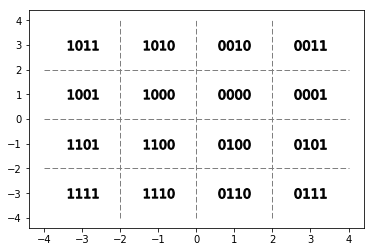

In [58]:
from lab04 import lab04

lab04.constellation_configuration()

![](https://latex.codecogs.com/gif.latex?simbolo%20%3D%20%5Ctheta_1%20%5Ccdot%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20cos%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29%20&plus;%20%5Ctheta_2%20%5Ccdot%20%5Csqrt%7B%5Cfrac%7B2%7D%7Bp%7D%7D%20%5Ccdot%20sin%282%20%5Cpi%20%5Ccdot%20n%20%5Ccdot%20%5Cfrac%7B1%7D%7Bp%7D%29)

```python
def qam_encode(x: np.ndarray, p: np.int) -> (np.ndarray, np.ndarray, np.int):
    coords, new_bits = constellation_encode(x)
    n = np.reshape(np.arange(p), (1, p))
    symbols = np.zeros((len(coords), np.int(len(coords[0]) / 2 * p)), dtype=np.float32)

    for i in range(0, len(coords[0]), 2):
        col_x = np.reshape(coords[:, i + 0], (len(coords), 1))
        col_y = np.reshape(coords[:, i + 1], (len(coords), 1))

        j = np.int(p / 2 * i)
        symbols[:, j:j + p] = col_x * np.sqrt(2 / p) * np.cos(2 * np.pi * n * 1 / p) +\
                              col_y * np.sqrt(2 / p) * np.sin(2 * np.pi * n * 1 / p)

    return symbols, coords, new_bits
    
def constellation_encode(x: np.ndarray) -> (np.ndarray, np.int):
    # the constellation uses 4 bits and converts them to coordinates
    # the received matrix may not have a column length multiple of 4
    # so we need to add them now and remove them in the decode function
    multiple = len(x[0]) % 4
    new_bits = 0

    if multiple != 0:
        new_bits = 4 - multiple
        x = np.concatenate((x, np.zeros((len(x), new_bits), dtype=np.int8)), axis=1)

    coords = np.zeros((len(x), np.int(len(x[0]) / 2)), dtype=np.int8)

    # based on the constellation codification calculate the signal and
    # the (x, y) coordinate
    def signal_calc(s):
        return -2 * s + 1

    def coord_calc(c):
        return 2 * c + 1

    for i in range(0, len(coords[0]), 2):
        # calc all signals of x and y
        signal = signal_calc(x[:, i * 2:i * 2 + 2])

        # calc all values of coord x and y
        coord = coord_calc(x[:, i * 2 + 2:i * 2 + 4])

        coords[:, i:i + 2] = np.transpose(np.array([signal[:, 0] * coord[:, 1], signal[:, 1] * coord[:, 0]]))

    return coords, new_bits
```

```python
def qam_decode(y: np.ndarray, p: np.int, rm_bits: np.int) -> (np.ndarray, np.ndarray):
    n = np.reshape(np.arange(p), (1, p))
    c1 = np.sqrt(2 / p) * np.cos(2 * np.pi * n * 1 / p)
    c2 = np.sqrt(2 / p) * np.sin(2 * np.pi * n * 1 / p)
    coords_r = np.zeros((len(y), np.int(len(y[0]) * 2 / p)))
    coords_p = np.zeros((len(y), np.int(len(y[0]) * 2 / p)))

    def cell_round(c):
        return 2 * np.ceil(c / 2) - 1

    for i in range(0, len(coords_r[0]), 2):
        j = np.int(p / 2 * i)
        symbols = y[:, j:j + p]

        phi_x = np.sum(symbols * c1, axis=1)
        phi_y = np.sum(symbols * c2, axis=1)

        coords_p[:, i + 0] = phi_x
        coords_p[:, i + 1] = phi_y
        coords_r[:, i + 0] = cell_round(phi_x)
        coords_r[:, i + 1] = cell_round(phi_y)

    coords_r = np.clip(coords_r, -3, 3)

    return constellation_decode(coords_r, rm_bits), coords_r, coords_p
    
def constellation_decode(y: np.ndarray, rm_bits: np.int) -> np.ndarray:
    bits = np.zeros((len(y), np.int(len(y[0]) * 2)), dtype=np.int8)

    for i in range(0, len(y[0]), 2):
        signal_x = (y[:, i + 0] < 0) * 1
        signal_y = (y[:, i + 1] < 0) * 1

        bit_x = np.array((np.abs(y[:, i + 0]) - 1) / 2, dtype=np.uint8)
        bit_y = np.array((np.abs(y[:, i + 1]) - 1) / 2, dtype=np.uint8)

        j = i * 2
        bits[:, j:j + 4] = np.transpose(np.array([signal_x, signal_y, bit_y, bit_x]))

    if rm_bits != 0:
        return bits[:, 0:-1 * rm_bits]

    return bits
```

In [ ]:
O **canal** e a simulacao da transmissao num meio fisico com erro AWGN

```python
def send_with_awgn(x: np.ndarray, sigma: np.float) -> np.ndarray:
    vector = matrix_to_vector(x)

    # Generate error/noise to simulate channel communication
    y = vector + sigma * np.random.randn(len(vector))

    return vector_to_matrix(y, len(x[0]))
```

# Resultados

* Resultados produzidos com a simulacao

* Correr o lab04 passo a passo, analisar e comentar os resultados

# Conclusoes

* O que correu bem
* Optimizacoes possiveis
* Alteracoes futuras
* Casos praticos
* Simulacao virtual vs simulacao fisica

# Bibliografia

* Sebenta CPS?